## Assignment 5

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from scipy import stats

import pystan

import matplotlib
import matplotlib.pyplot as plt

font = {'size': 16}

matplotlib.rc('font', **font)

### 1. Generalized linear model with Metropolis

We use the same data as given in the book (table 3.1)

In [2]:
# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

df = pd.DataFrame({
    'Sample': np.arange(4) + 1,
    'Dose (log g/ml)': x,
    'Number of animals': n,
    'Number of deaths': y
}).set_index('Sample')
df

,Dose (log g/ml),Number of animals,Number of deaths
Sample,,,
1,-0.86,5,0
2,-0.30,5,1
3,-0.05,5,3
4,0.73,5,5


We define the unnormalized distribution $q(X)$ of a single sample:

In [3]:
def q(X):    
    a, b = X[0], X[1]
    ilogit_abx = 1 / (np.exp(-(a + b * x)) + 1)
    log_likelihood = np.sum(np.log(ilogit_abx**y) + np.log((1 - ilogit_abx)**(n - y)))
    return np.exp(log_likelihood)

Parameters for Metropolis-algorithm. We sample 4000 sampeles with a warm-up of 4000 (so in total 8000 samples will be taken, but we drop the first 1000). Since the starting point is arbitrary we can choose $(a, b) = (0, 0)$. 

In [12]:
num_samp = 4000          # Number of samplte to pick
samp = np.array([0, 0])  # Initial proposal at start
samps = [samp]           # List of accepted samples
bootstrap_size = 4000    # Number of samples to skip for warm up

The Metropolis algorithm runs iterations until number of samples to pick is achieved. For each iteration $t$ it does the following [1]:
- Generate : Generate a candidate $\mathrm{prop}_t$ for the next sample by picking from the distribution $g(\mathrm{prop}_t \; | \; \mathrm{samp}_{t-1})$. Here we use a gausian distribution for $g$ with mean $\mathrm{samp}_{t-1}$ and scale 1.
- Calculate : Calculate the acceptance ratio $r = q(\mathrm{prop}_t)/q(samp_{t-1})$, which will be used to decide whether to accept or reject the candidate. 
- Accept or Reject :
  - Generate a uniform random number $u$ on $[0,1[$.
  - If $u \leq r$ accept the candidate by setting $\mathrm{samp}_{t} = \mathrm{prop}_{t}$,
  - If $ u > r$ reject the candidate and set $\mathrm{samp}_{t} = \mathrm{samp}_{t - 1}$, instead.

In [13]:
# keep sampling until we have the desired number of samples
while len(samps) < bootstrap_size + num_samp:
    # get new proposal
    prop = np.random.normal(loc=samps[-1])
    r = np.divide(q(prop), q(samps[-1]))
    u = np.random.uniform()    
    if u <= r:
        samps.append(prop)

# remove warm-up samples
samps = np.array(samps)[bootstrap_size:]

We check the mean of the samples:

In [14]:
np.mean(samps, axis = 0)

array([ 1.50496811, 13.10736905])

We plot the samples:

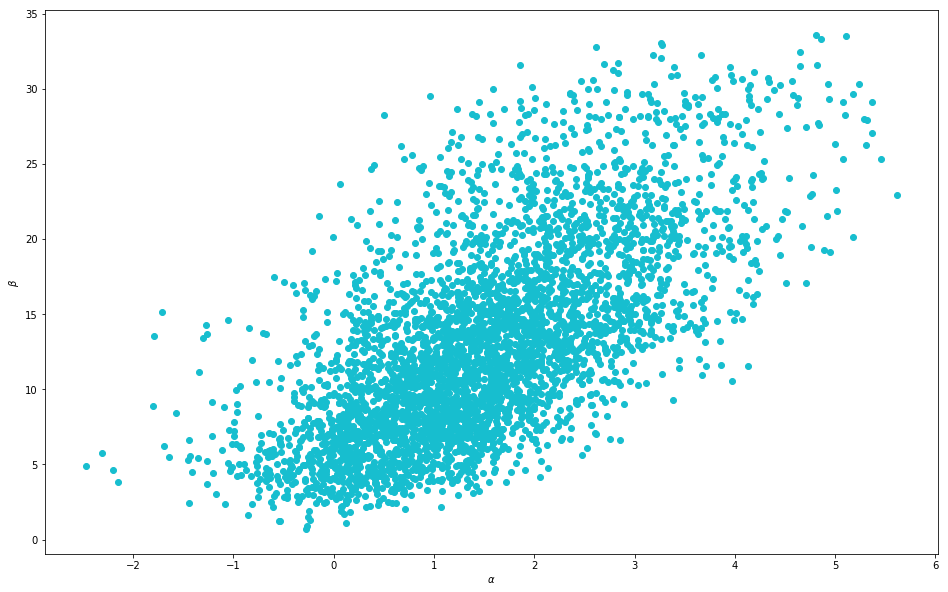

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16, 10))
ax.plot(samps[:,0],samps[:,1], 'o', color = 'C9')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
None

We calculate $\hat{R}$ cf. BDA (p. 284-285):

In [59]:
# split chain into two equal parts
splitted_chains = np.array(np.split(samps, 2))
m = splitted_chains.shape[0]
n = splitted_chains.shape[1]
W = np.mean(np.var(splitted_samples, axis = 1, ddof = 1), axis = 0) # eq. is equal to mean of var.
psi_dot_j = np.mean(splitted_chains, axis = 1)
B = n * np.var(psi_dot_j, axis = 0, ddof = 1) # eq. is equal to var of mean of psi_dot_j.
var_hat = (n - 1) / n * W + 1 / n * B # eq. (11.3)
R_hat = np.sqrt(var_hat / W) # eq. (11.4)

We get the following R hat values, which are acceptable:

In [60]:
print('R hat alpha : {:.3f}'.format(R_hat[0]))
print('R hat beta  : {:.3f}'.format(R_hat[1]))

R hat alpha : 1.015
R hat beta  : 1.037


To plot the sampled density we use kernel density estimation:

In [16]:
a = samps[:,0]
b = samps[:,1]
samp_kde = stats.kde.gaussian_kde([a, b])

And calculate grid for plotting heatmap

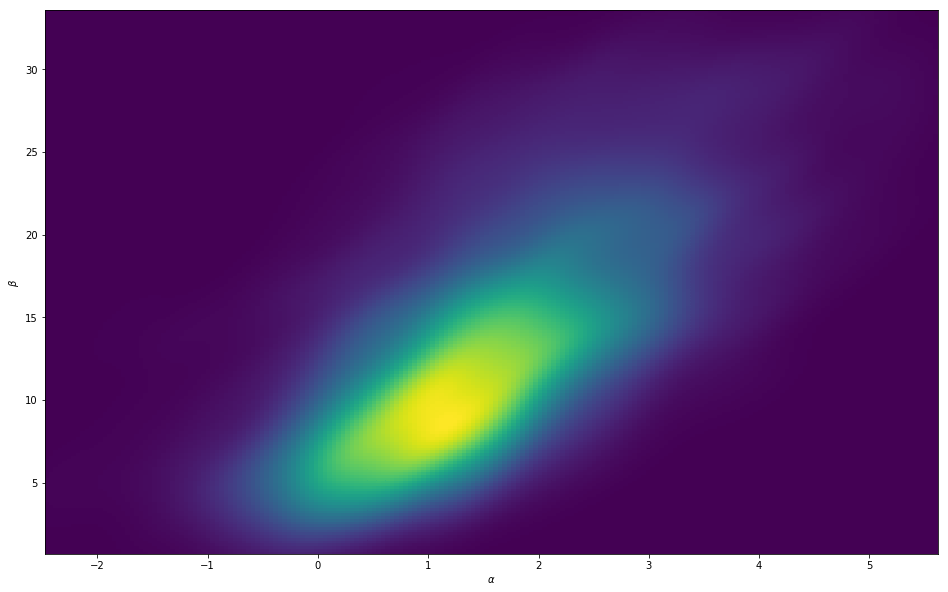

In [17]:
nbins = 200
ai, bi = np.mgrid[a.min():a.max():nbins*1j, b.min():b.max():nbins*1j]
pi = samp_kde(np.vstack([ai.flatten(), bi.flatten()]))

# Make the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (16, 10))
ax.pcolormesh(ai, bi, pi.reshape(ai.shape))
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
plt.show()

We see that the heatmap looks similar to the one produced in the previous assignment

### Generalized linear model: Bioassay with Stan

In [18]:
stan_code = """
data {
    real x[4];
    int n[4];
    int y[4];
}
parameters {
    real alpha;
    real beta;
}
transformed parameters {
    real logits[4];
    logits[1] <- alpha + beta * x[1];
    logits[2] <- alpha + beta * x[2];
    logits[3] <- alpha + beta * x[3];
    logits[4] <- alpha + beta * x[4];
}
model {
    y ~ binomial_logit(n, logits);
}
"""

stan_data = {
    'x': x,
    'n': n,
    'y': y
}

fit = pystan.stan(model_code=stan_code, data=stan_data, iter=4000)
params = fit.extract()
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c2104d3a845be14e7c630b78c1594f9 NOW.
c:\users\ncp\appdata\local\continuum\anaconda3\envs\stan_env\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_4c2104d3a845be14e7c630b78c1594f9.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha       1.32    0.02    1.1  -0.52   0.54   1.23   1.96   3.86   2202    1.0
beta        11.6    0.13   5.84   3.43   7.36  10.55  14.75  25.48   1955    1.0
logits[0]  -8.66    0.09   4.38  -19.2  -11.0  -7.86  -5.51  -2.53   2132    1.0
logits[1]  -2.16    0.02   1.33  -5.26  -2.86  -1.96  -1.26  -0.16   3079    1.0
logits[2]   0.74    0.02   0.94  -0.93    0.1   0.67   1.31   2.83   2618    1.0
logits[3]   9.78    0.12   5.05   2.55   6.06   8.91  12.59  21.95   1873    1.0
lp__        -7.0    0.03   1.16 -10.09  -7.42  -6.64  -6.19  -5.92   1956    1.0

Samples were drawn using NUTS at Mon Mar  5 09:48:14 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale 

We plot the samples from the stan-model side by side with the Metropolis draws:

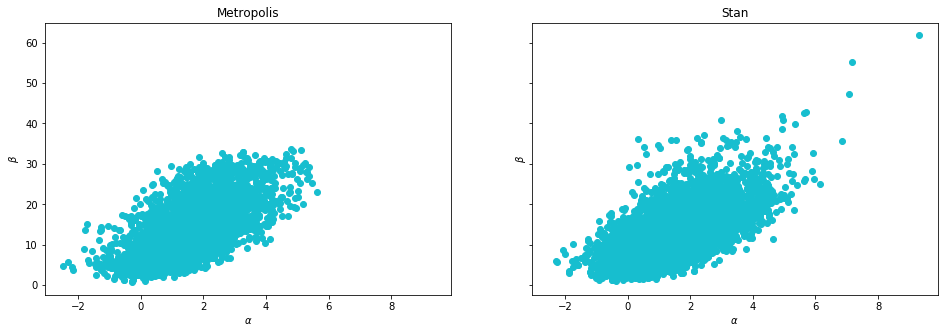

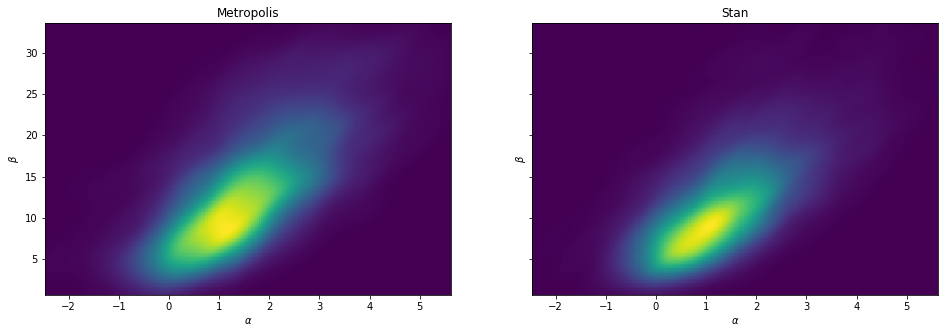

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 5), sharex = True, sharey = True)
ax[0].set_title('Metropolis')
ax[0].plot(samps[:,0],samps[:,1], 'o', color = 'C9')
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[1].set_title('Stan')
ax[1].plot(params['alpha'], params['beta'], 'o', color = 'C9')
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel(r'$\beta$')
[(
    [tk.set_visible(True) for tk in ax.get_yticklabels()], 
    [tk.set_visible(True) for tk in ax.get_yticklabels()]
 ) for ax in ax.flatten()]

stan_kde = stats.kde.gaussian_kde([params['alpha'], params['beta']])
stan_p = stan_kde(np.vstack([ai.flatten(), bi.flatten()]))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16, 5), sharex = True, sharey = True)
ax[0].set_title('Metropolis')
ax[0].pcolormesh(ai, bi, pi.reshape(ai.shape))
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[1].set_title('Stan')
ax[1].pcolormesh(ai, bi, stan_p.reshape(ai.shape))
ax[1].set_xlabel(r'$\alpha$')
ax[1].set_ylabel(r'$\beta$')

None

We see the to models looks similar, even though the Stan-model seems more smooth, and closer to the grid-reference.

### References
[1] [Metropolis–Hastings algorithm, Wikipedia](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)